## Importing packages

In [1]:
import sys
sys.path.append('/home/class_NI2021/ctxctl_contrib_2023')
import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import os

## Looking for available devices

In [2]:
# Checking the list of unopened devices
devices = samna.device.get_unopened_devices()

if len(devices) == 0:
    raise Exception("no device detected!")

for i in range(len(devices)):
    print("["+str(i)+"]: ", devices[i], "serial_number", devices[i].serial_number)

[0]:  Bus 3 Device 5 Dynapse1DevKit serial_number 00000007
[1]:  Bus 3 Device 4 Dynapse1DevKit serial_number 00000000
[2]:  Bus 1 Device 3 Dynapse1DevKit serial_number 00000031
[3]:  Bus 1 Device 2 Dynapse1DevKit serial_number 00000001


In [3]:
# Select one device from the list
model,no_gui = ut.open_dynapse1(gui=False, sender_port=17654, receiver_port=17523, select_device=True) # returns Dynapse1Model

ERROR: Address already in use, please re-run open_device()!
[0]:  Bus 3 Device 5 Dynapse1DevKit serial_number 00000007
[1]:  Bus 3 Device 4 Dynapse1DevKit serial_number 00000000
[2]:  Bus 1 Device 3 Dynapse1DevKit serial_number 00000031
[3]:  Bus 1 Device 2 Dynapse1DevKit serial_number 00000001
Sender port: tcp://0.0.0.0:17654
Receiver port: tcp://0.0.0.0:17523
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2
0 Dynapse1Wrapper created! libcaer init...
Clearing chip 0... DONE.
Clearing chip 1... DONE.
Clearing chip 2... DONE.
Clearing chip 3... DONE.


## Experimentation
### Cleaning parameters

In [84]:
# silent all neurons: enforces some biases to ensure neurons are NOT firing
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

### Network design

In [19]:
api  = model.get_dynapse1_api()

# ---- Parameters ----
n_inputs = 3
n_delay = 1
factor = 1

# ---- Spike generator ----
spike_generator_ids = range(1, n_inputs + 2)
spike_generators = n.NeuronGroup(0, 0, spike_generator_ids, True)  # Avoid spike generator with ID 0

# ---- DPI Neurons ----
id_ini = 1
id_end = id_ini + n_delay
delay_pop = n.NeuronGroup(0, 1, range(id_ini, id_end), False)

id_ini = id_end
id_end += n_inputs
not_pop = n.NeuronGroup(0, 1, range(id_ini, id_end), False)

id_ini = id_end
id_end += 1
nor_pop = n.NeuronGroup(0, 1, range(id_ini, id_end), False)

# ---- Synapses ----
net_gen = n.NetworkGenerator()

# OP delayed
net_gen.add_connection(spike_generators.neurons[0], delay_pop.neurons[0], dyn1.Dynapse1SynType.AMPA)
for i in range(1, n_delay):
    net_gen.add_connection(delay_pop.neurons[i - 1], delay_pop.neurons[i], dyn1.Dynapse1SynType.AMPA)

# OP to NOT
for i in range(n_inputs):
    net_gen.add_connection(spike_generators.neurons[0], not_pop.neurons[i], dyn1.Dynapse1SynType.AMPA)

# OP to NOR
net_gen.add_connection(delay_pop.neurons[-1], nor_pop.neurons[0], dyn1.Dynapse1SynType.AMPA)

# Inputs to NOT
for i in range(n_inputs):
    net_gen.add_connection(spike_generators.neurons[i + 1], not_pop.neurons[i], dyn1.Dynapse1SynType.GABA_B)

# NOT to NOR
for i in range(n_inputs):
    net_gen.add_connection(not_pop.neurons[i], nor_pop.neurons[0], dyn1.Dynapse1SynType.GABA_B)

print(net_gen.network)

Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C0c1n1: [('C0c0s1', 'AMPA')]
C0c1n2: [('C0c0s1', 'AMPA'), ('C0c0s2', 'GABA_B')]
C0c1n3: [('C0c0s1', 'AMPA'), ('C0c0s3', 'GABA_B')]
C0c1n4: [('C0c0s1', 'AMPA'), ('C0c0s4', 'GABA_B')]
C0c1n5: [('C0c1n1', 'AMPA'), ('C0c1n2', 'GABA_B'), ('C0c1n3', 'GABA_B'), ('C0c1n4', 'GABA_B')]



### Applying the network configuration

In [20]:
# make a dynapse1config using the network: that is convert the validated network to a Dynapse1 configuration
new_config = net_gen.make_dynapse1_configuration()

# apply the configuration
model.apply_configuration(new_config)

New configuration applied to DYNAP-SE1!


### Parameters

In [21]:
# Initialize custom parameters for a core and a chip:
paramGroup = dyn1.Dynapse1ParameterGroup() 
paramGroup.param_map["IF_THR_N"].coarse_value = 7
paramGroup.param_map["IF_THR_N"].fine_value = 32
paramGroup.param_map["IF_RFR_N"].coarse_value = 7  # Inverse
paramGroup.param_map["IF_RFR_N"].fine_value = 255  # Inverse
paramGroup.param_map["IF_TAU1_N"].coarse_value = 6  # Inverse
paramGroup.param_map["IF_TAU1_N"].fine_value = 191  # Inverse
paramGroup.param_map["IF_DC_P"].coarse_value = 0
paramGroup.param_map["IF_DC_P"].fine_value = 0

# Fast excitatory synapse (AMPA)
paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 6
paramGroup.param_map["NPDPIE_THR_F_P"].fine_value =  127
paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value =  127
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 255

# Fast inhibitory synapse (GABA_B)
paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 6
paramGroup.param_map["NPDPII_THR_S_P"].fine_value =  127
paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 4
paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 127
paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 7
paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 255

# Apply the custom parameters to the core
model.update_parameter_group(paramGroup, not_pop.chip_id, not_pop.core_id)

### Setting up the spike generator

In [22]:
fpga_spike_gen = model.get_fpga_spike_gen()

import random
# print(*np.sort(np.array(random.sample(op_times, 20))), sep=", ")
op_times = [0,  1,  2,  4,  6,  7,  8,  9, 10, 12, 13, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 40, 41,
       42, 44, 45, 46, 48, 49]
sg_times = [np.concatenate([np.array(op_times) / (1000 * factor) + 0.05, [0.400, 0.401]], axis=0)]

in_times = []
for i in range(n_inputs):
    times = np.arange(20, 30)
    times = np.sort(list(set(np.append(times, random.sample(op_times, 20)))))
    #times = np.copy(op_times)
    in_times.append(times)
    sg_times.append(times / (1000 * factor) + 0.05)

spike_times = np.concatenate(sg_times, axis=0)
gen_neuron_ids = np.concatenate([[i+1] * len(sg_times[i]) for i in range(len(sg_times))], axis=0)  # Spike generator associated to the spike at that index
spike_times, gen_neuron_ids = map(list, zip(*sorted(zip(spike_times, gen_neuron_ids), reverse=False)))

post_neuron_chips = [0] * len(gen_neuron_ids)

isi_base = 900
repeat_mode = False
ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, gen_neuron_ids, post_neuron_chips, isi_base, repeat_mode)

VariableIsiMode already 1
RepeatMode already 0


### Getting spikes

In [23]:
monitored_neurons = np.concatenate([delay_pop.tuple_neuron_ids, not_pop.tuple_neuron_ids, nor_pop.tuple_neuron_ids], axis=0)
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, monitored_neurons)

api.reset_timestamp()
graph.start()
sink_node.get_events()
fpga_spike_gen.start()

if(spike_times[-1] - 0.2 < 0):
    time.sleep(spike_times[-1])
else:
    time.sleep(spike_times[-1] - 0.2)  # Last spike time - 0.2

fpga_spike_gen.stop()
time.sleep(0.5)
events = sink_node.get_events()
graph.stop()

True

In [24]:
evts_n = np.array([[evt.timestamp / 10**6 + spike_times[0], evt.neuron_id] for evt in events])

save_array = [sg_times, evts_n]
test_name = "inh_and_" + str(n_inputs) + "inputs_factor" + str(factor)

cwd = os.getcwd()
if not os.path.exists(cwd + "/experiments/"):
    os.mkdir(cwd + "/experiments/")

i = 1
while os.path.exists(cwd + "/experiments/" + test_name + "_" + str(i) + ".pickle"):
    i += 1

filename = test_name + "_" + str(i)

with open("experiments/" + filename + '.pickle', 'wb') as handle:
    pickle.dump(save_array, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open("experiments/" + filename + '.pickle', "rb") as handle:
    print(pickle.load(handle))

[[array([0.05 , 0.051, 0.052, 0.054, 0.056, 0.057, 0.058, 0.059, 0.06 ,
       0.062, 0.063, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071,
       0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 ,
       0.081, 0.083, 0.086, 0.087, 0.088, 0.09 , 0.091, 0.092, 0.094,
       0.095, 0.096, 0.098, 0.099, 0.4  , 0.401]), array([0.051, 0.054, 0.06 , 0.062, 0.065, 0.066, 0.068, 0.069, 0.07 ,
       0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079,
       0.08 , 0.086, 0.088, 0.091, 0.092, 0.094, 0.098]), array([0.051, 0.056, 0.058, 0.059, 0.065, 0.066, 0.067, 0.069, 0.07 ,
       0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079,
       0.083, 0.087, 0.091, 0.092, 0.094, 0.095, 0.096, 0.099]), array([0.056, 0.057, 0.058, 0.06 , 0.066, 0.067, 0.068, 0.069, 0.07 ,
       0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079,
       0.08 , 0.081, 0.088, 0.092, 0.094, 0.098, 0.099])], array([[0.050373, 4.      ],
       [0.050381, 1.      ],
       

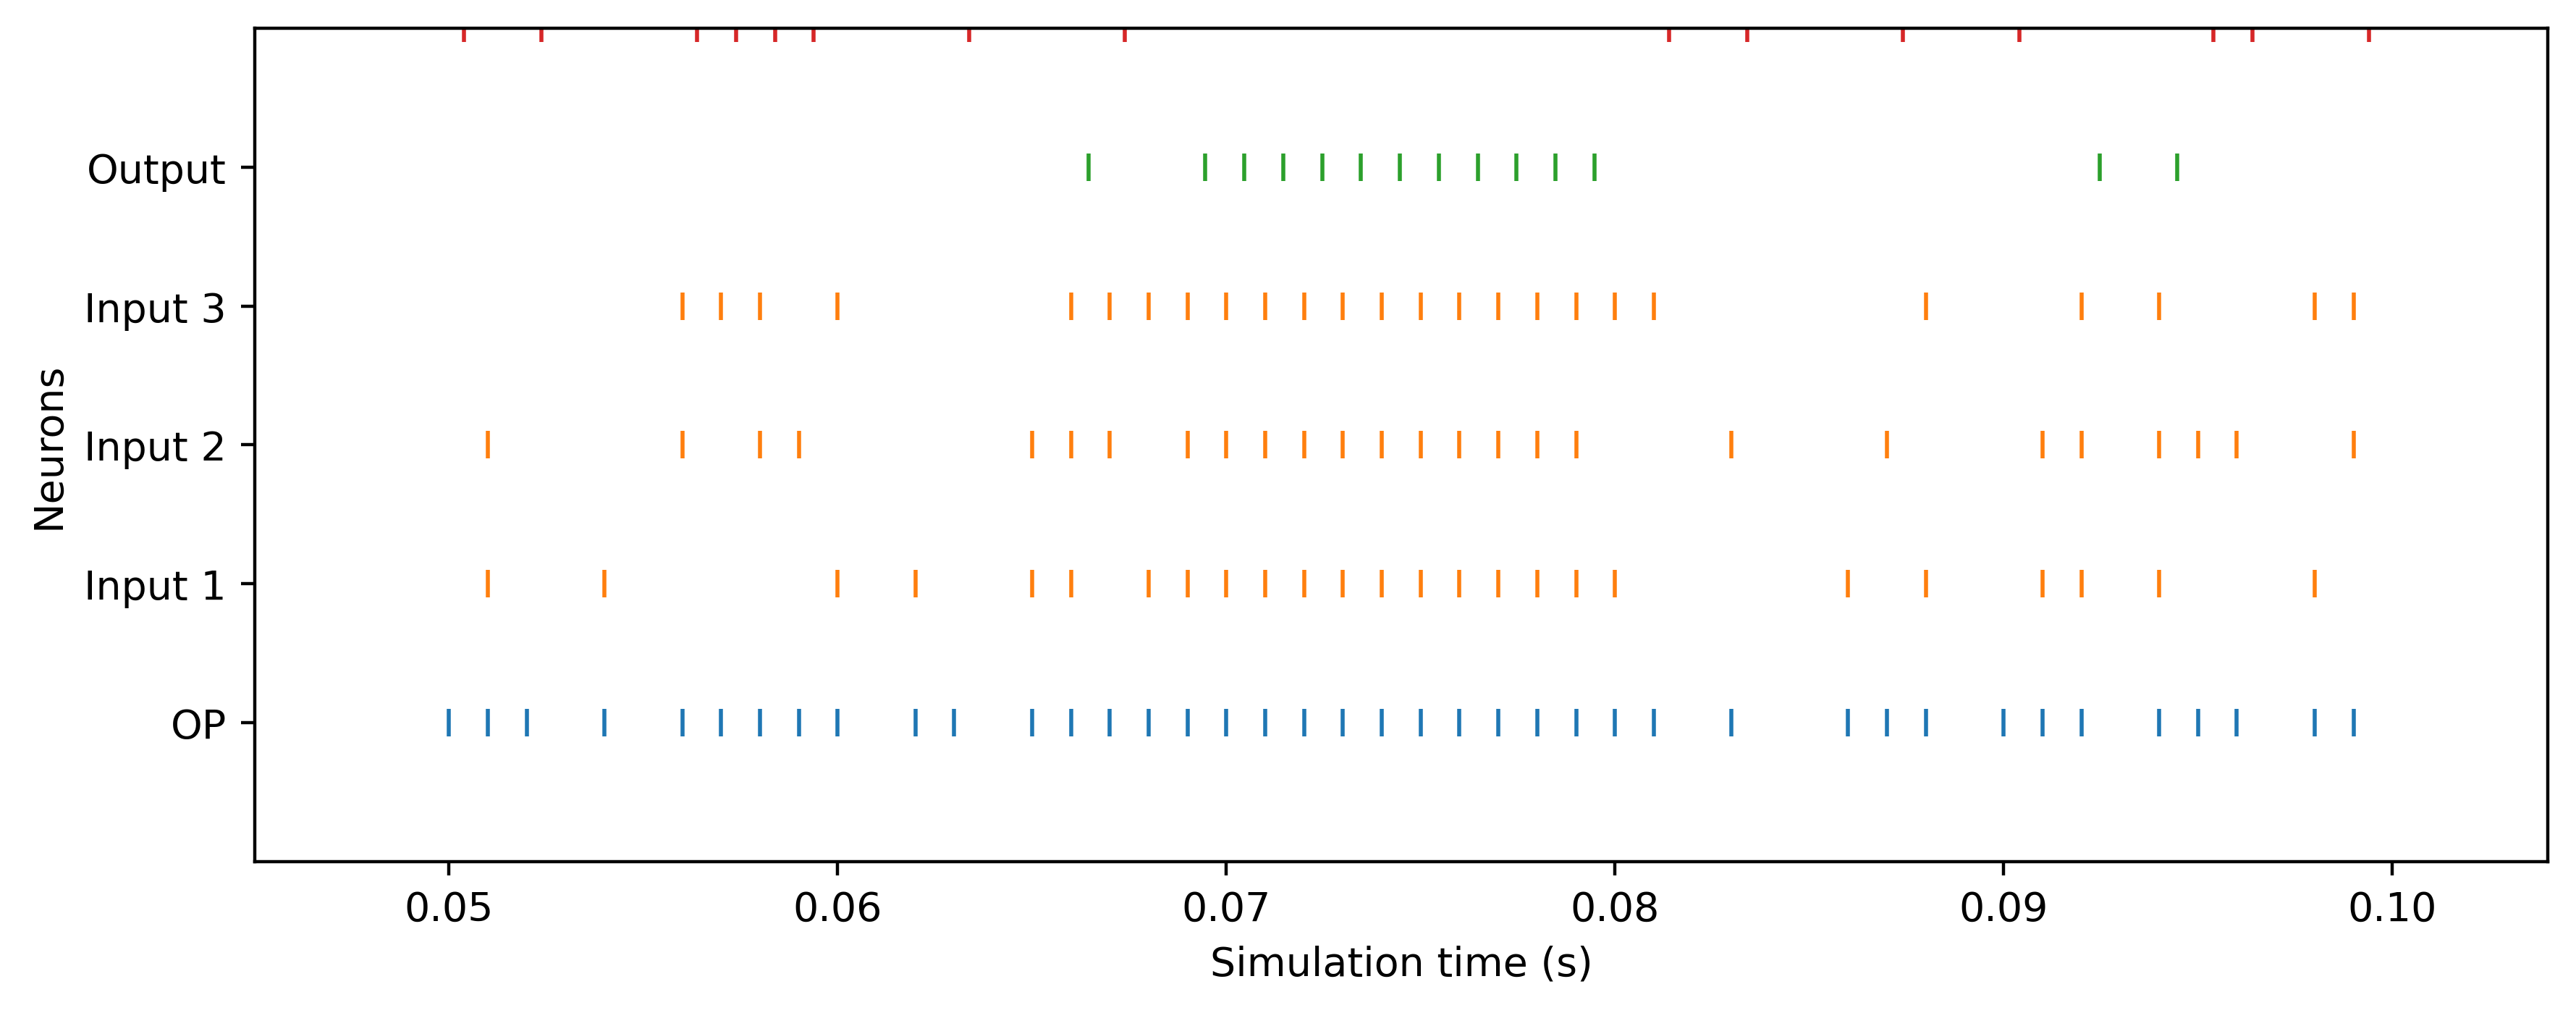

In [25]:
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = [9, 1.8 + 1.8 / 3 * n_inputs]

plt.plot(sg_times[0], [1] * len(sg_times[0]), color='tab:blue', linestyle = 'None', marker='|', markersize=7)
for i in range(1, n_inputs + 1):
    plt.plot(sg_times[i], [i+1] * len(sg_times[i]), color='tab:orange', linestyle = 'None', marker='|', markersize=7)
plt.xlabel('Simulation time (s)')
plt.yticks(range(1, n_inputs + 3))
plt.gca().set_yticklabels(["OP"] + ["Input " + str(i) for i in range(1, n_inputs + 1)] + ["Output"])
plt.ylabel("Neurons")
plt.xlim([0.05 - 0.005 / factor, sg_times[0][-3] + 0.005 / factor])
plt.ylim([0, n_inputs + 3])

evts_nor = np.array([[evt.timestamp / 10**6 + spike_times[0], evt.neuron_id] for evt in events if evt.neuron_id in nor_pop.neuron_ids])
if len(evts_nor) == 0:
    print("Output spikes were not detected")
else:
    plt.plot(evts_nor[:,0], [n_inputs + 2] * len(evts_nor[:,0]), color='tab:green', linestyle = 'None', marker='|', markersize=7)

evts_not = np.array([[evt.timestamp / 10**6 + spike_times[0], evt.neuron_id] for evt in events if evt.neuron_id in not_pop.neuron_ids])
if len(evts_not) == 0:
    print("NOT spikes were not detected")
else:
    plt.plot(evts_not[:,0], n_inputs + 1 + evts_not[:,1], color='tab:red', linestyle = 'None', marker='|', markersize=7)

plt.tight_layout()

plt.savefig("experiments/" + filename + '.png', transparent=False, facecolor='white', edgecolor='black')

In [92]:
print(evts_not)

[[ 0.101017  7.      ]
 [ 0.101021 21.      ]
 [ 0.101024  4.      ]
 [ 0.101025 19.      ]
 [ 0.101026 15.      ]
 [ 0.101027 29.      ]
 [ 0.101027 18.      ]
 [ 0.101028 23.      ]
 [ 0.101029  8.      ]
 [ 0.10103  20.      ]
 [ 0.101033 17.      ]
 [ 0.101033  3.      ]
 [ 0.101034 25.      ]
 [ 0.101034 30.      ]
 [ 0.101034 13.      ]
 [ 0.101034  5.      ]
 [ 0.101035 14.      ]
 [ 0.101035  6.      ]
 [ 0.101035 22.      ]
 [ 0.101036 16.      ]
 [ 0.101036 31.      ]
 [ 0.101037  2.      ]
 [ 0.101038 11.      ]
 [ 0.101039 12.      ]
 [ 0.10104  26.      ]
 [ 0.10104  24.      ]
 [ 0.101041 28.      ]
 [ 0.101042 10.      ]
 [ 0.101047  9.      ]
 [ 0.101048 27.      ]
 [ 0.152338  7.      ]
 [ 0.152342 21.      ]
 [ 0.152346  4.      ]
 [ 0.152347 19.      ]
 [ 0.152348 15.      ]
 [ 0.152348 29.      ]
 [ 0.152348 18.      ]
 [ 0.152349 23.      ]
 [ 0.152351  8.      ]
 [ 0.152352 20.      ]
 [ 0.152354  3.      ]
 [ 0.152355 17.      ]
 [ 0.152355 30.      ]
 [ 0.152355

### Comparing Spikes

In [30]:
intersection = sg_times[0]
for i in range(n_inputs):
    intersection = np.intersect1d(intersection, sg_times[i + 1])

if len(evts_nor[:,0]) == len(intersection):
    print("OK!")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Close the device

In [93]:
# remeber to close the device
samna.device.close_device(model)